In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
# 이거 실행하고 다시 런타임 시작
# 한글 폰트
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf


Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

# 필요 라이브러리 설치 및 데이터 업로드

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import plotly.express as px
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, StratifiedKFold
sns.set(font='NaNumBarunGothic')



%matplotlib inline

In [218]:
# 고객군 Cluster 분류된 상품구매정보 받아오기
pdde_cluster = pd.read_csv('/content/drive/MyDrive/롯데멤버스_빅데이터경진대회/k_means_clustering_pdde(3).csv', encoding='cp949')

# 고객군 Cluster 분류된 제휴사이용정보 받아오기
cop_cluster = pd.read_csv('/content/drive/MyDrive/롯데멤버스_빅데이터경진대회/cop_latent.csv', encoding='cp949')

# 고객군 Cluster 분류된 엘페이이용정보 받아오기
lpay_cluster = pd.read_csv('/content/drive/MyDrive/롯데멤버스_빅데이터경진대회/lpay_latent.csv', encoding='cp949')


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (8,17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [219]:
pdde_cluster.replace({'ma_fem_dv': {0: '남성', 1: '여성'},
              'ages': {0: '20대',1: '30대', 2: '40대', 3: '50대', 4: '60대', 5: '70대' }},inplace=True)
cop_cluster.replace({'ma_fem_dv': {0: '남성', 1: '여성'},
              'ages': {0: '20대',1: '30대', 2: '40대', 3: '50대', 4: '60대', 5: '70대' }},inplace=True)
lpay_cluster.replace({'ma_fem_dv': {0: '남성', 1: '여성'},
              'ages': {0: '20대',1: '30대', 2: '40대', 3: '50대', 4: '60대', 5: '70대' }},inplace=True)


In [220]:
lpay_cluster.columns

Index(['cust', 'rct_no', 'cop_c', 'chnl_dv', 'de_dt', 'de_hr', 'buy_am',
       'ma_fem_dv', 'ages', 'zon_hlv', '날짜', '강수량(mm)', '평균기온(℃)', '최저기온(℃)',
       '최고기온(℃)', '평균습도(%rh)', '최저습도(%rh)', '일조합(hr)', '일사합(MJ/m2)', 'year',
       'month', '요일', '일교차', '불쾌지수', 'holiday_anniversary', 'k_mean_cluster',
       'clac_hlv_nm'],
      dtype='object')

In [221]:
# 파생변수 생성
pdde_cluster['상품가'] = pdde_cluster['buy_am']/pdde_cluster['buy_ct']
cop_cluster['상품가'] = cop_cluster['buy_am']/cop_cluster['de_hr']
lpay_cluster['상품가'] = lpay_cluster['buy_am']/lpay_cluster['de_hr']


In [222]:
print(f'pdde 전체 데이터 : {pdde_cluster.shape}')
print(f'cop 전체 데이터 : {cop_cluster.shape}')
print(f'lpay 전체 데이터 : {lpay_cluster.shape}')
print()
print('--------------오프라인 한정해서 뽑기--------------------')

# 오프라인만 한정
pdde_cluster = pdde_cluster[pdde_cluster['chnl_dv']==1].reset_index(drop=True)
cop_cluster = cop_cluster[cop_cluster['chnl_dv']==1].reset_index(drop=True)
lpay_cluster = lpay_cluster[lpay_cluster['chnl_dv']==1].reset_index(drop=True)

print()
print(f'pdde 전체 데이터 : {pdde_cluster.shape}')
print(f'cop 전체 데이터 : {cop_cluster.shape}')
print(f'lpay 전체 데이터 : {lpay_cluster.shape}')

pdde 전체 데이터 : (4381743, 34)
cop 전체 데이터 : (248247, 32)
lpay 전체 데이터 : (353184, 28)

--------------오프라인 한정해서 뽑기--------------------

pdde 전체 데이터 : (3953242, 34)
cop 전체 데이터 : (213520, 32)
lpay 전체 데이터 : (150010, 28)


In [197]:
3953242/4381743

0.9022076374629914

In [223]:
# 일단 상품구매정보에서 클러스터별 상품 대분류 비중 확인

# 상품구매정보 데이터에서 클러스터 0 df만들기
pdde_cluster_0 = pdde_cluster[pdde_cluster['k_mean_cluster']==0].reset_index(drop=True)

# 상품구매정보 데이터에서 클러스터 1 df 만들기
pdde_cluster_1 = pdde_cluster[pdde_cluster['k_mean_cluster']==1].reset_index(drop=True)


# 상품구매정보 데이터에서 클러스터 2 df 만들기
pdde_cluster_2 = pdde_cluster[pdde_cluster['k_mean_cluster']==2].reset_index(drop=True)



# 제휴사이용 데이터에서 클러스터 0 df만들기
cop_cluster_0 = cop_cluster[cop_cluster['k_mean_cluster']==0].reset_index(drop=True)

# 제휴사이용 데이터에서 클러스터 1 df 만들기
cop_cluster_1 = cop_cluster[cop_cluster['k_mean_cluster']==1].reset_index(drop=True)


# 제휴사이용 데이터에서 클러스터 2 df 만들기
cop_cluster_2 = cop_cluster[cop_cluster['k_mean_cluster']==2].reset_index(drop=True)







# 엘페이이용 데이터에서 클러스터 0 df만들기
lpay_cluster_0 = lpay_cluster[lpay_cluster['k_mean_cluster']==0].reset_index(drop=True)

# 엘페이이용 데이터에서 클러스터 1 df 만들기
lpay_cluster_1 = lpay_cluster[lpay_cluster['k_mean_cluster']==1].reset_index(drop=True)


# 엘페이이용 데이터에서 클러스터 2 df 만들기
lpay_cluster_2 = lpay_cluster[lpay_cluster['k_mean_cluster']==2].reset_index(drop=True)

In [224]:
pdde_cluster.drop('Unnamed: 0', axis=1, inplace=True)

# 날짜타입으로 변경
pdde_cluster['de_dt'] = pdde_cluster['de_dt'].astype(str)
pdde_cluster['de_dt'] = pd.to_datetime(pdde_cluster['de_dt'])


# cop_cluster.drop('Unnamed: 0', axis=1, inplace=True)

# # 날짜타입으로 변경
# cop_cluster['de_dt'] = cop_cluster['de_dt'].astype(str)
# cop_cluster['de_dt'] = pd.to_datetime(cop_cluster['de_dt'])




# 날짜타입으로 변경
lpay_cluster['de_dt'] = lpay_cluster['de_dt'].astype(str)
lpay_cluster['de_dt'] = pd.to_datetime(lpay_cluster['de_dt'])

# 고객군 분석
- 구매력, 성별, 연령대 등 특징 파악


## 고객군 분포 확인

In [180]:
# 상품구매정보 고객군 분포
# color = sns.color_palette('pastel')[:10]
# wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
# pdde_cluster['k_mean_cluster'].value_counts().plot(kind = 'pie', autopct='%1.1f%%', colors = color, wedgeprops=wedgeprops)
# plt.ylabel('고객군')
# plt.title('상품구매데이터 고객군 분포')

Text(0.5, 1.0, '상품구매데이터 고객군 분포')

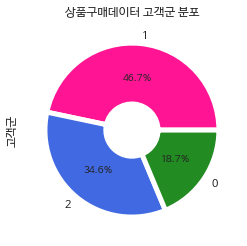

In [62]:
# 상품구매정보 고객군 분포
color = ['deeppink', 'royalblue','forestgreen']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
pdde_cluster['k_mean_cluster'].value_counts().plot(kind = 'pie', autopct='%1.1f%%', colors = color, wedgeprops=wedgeprops)
plt.ylabel('고객군')
plt.title('상품구매데이터 고객군 분포')


Text(0.5, 1.0, '제휴사이용 고객군 분포')

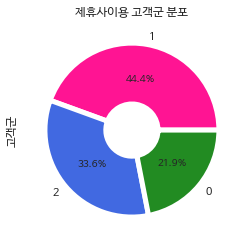

In [181]:
# 제휴사 고객군 분포
# color = sns.color_palette('pastel')[:10]
# wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
# cop_cluster['k_mean_cluster'].value_counts().plot(kind = 'pie', autopct='%1.1f%%', colors = color, wedgeprops=wedgeprops)
# plt.ylabel('고객군')
# plt.title('제휴사이용 고객군 분포')
color = ['deeppink', 'royalblue','forestgreen']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
cop_cluster['k_mean_cluster'].value_counts().plot(kind = 'pie', autopct='%1.1f%%', colors = color, wedgeprops=wedgeprops)
plt.ylabel('고객군')
plt.title('제휴사이용 고객군 분포')

In [178]:
# 엘페이 고객군 분포
# color = sns.color_palette('pastel')[:10]
# wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
# lpay_cluster['k_mean_cluster'].value_counts().plot(kind = 'pie', autopct='%1.1f%%', colors = color, wedgeprops=wedgeprops)
# plt.ylabel('고객군')
# plt.title('엘페이이용 고객군 분포')

Text(0.5, 1.0, '엘페이이용 데이터 고객군 분포')

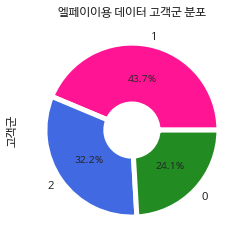

In [147]:
color = ['deeppink', 'royalblue','forestgreen']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
lpay_cluster['k_mean_cluster'].value_counts().plot(kind = 'pie', autopct='%1.1f%%', colors = color, wedgeprops=wedgeprops)
plt.ylabel('고객군')
plt.title('엘페이이용 데이터 고객군 분포')

## 고객군 연령대/성별 확인
- 우리는 구매력이 높은 2번 고객군에게 포커싱할것이다.
- 이에 따라 2번 고객군의 연령대/성별만 확인한다.

<Figure size 2160x504 with 0 Axes>

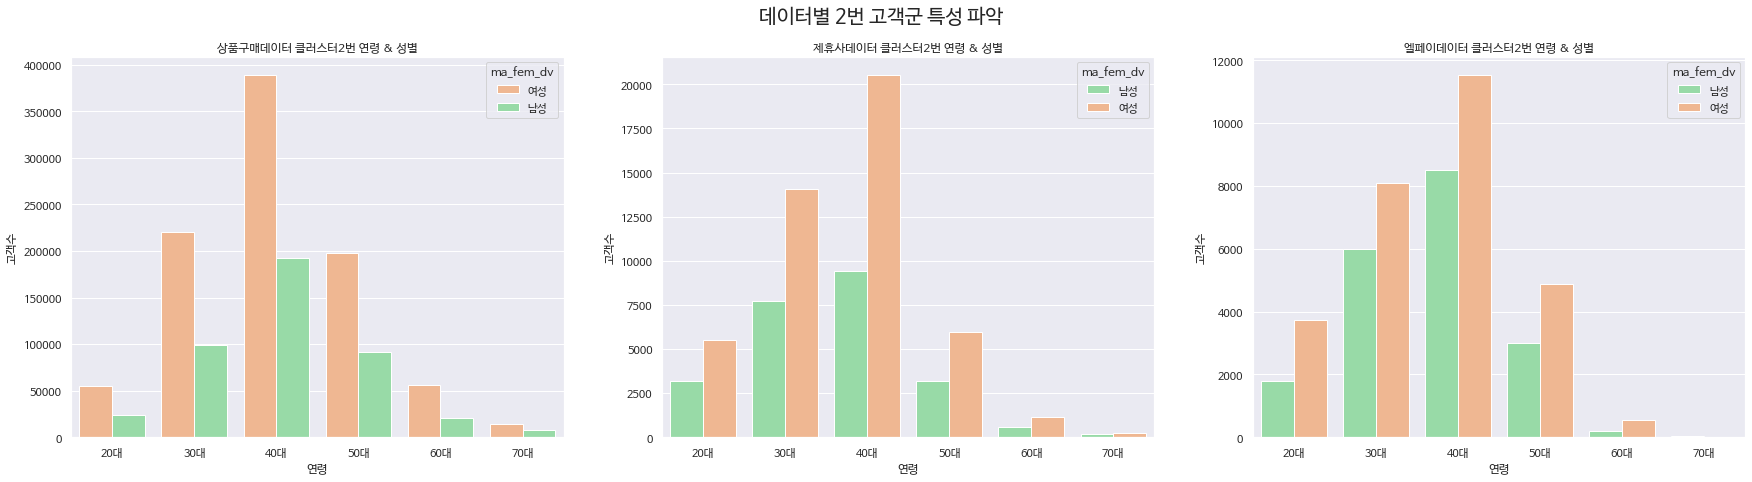

In [203]:
plt.figure(figsize = (30, 7))
fig, axes = plt.subplots(1,3,figsize=(30,7))
palette = sns.color_palette('pastel')


ax1 = sns.countplot(x='ages',hue = 'ma_fem_dv',data = pdde_cluster_2, palette = [palette[1], palette[2]], ax = axes[0], order = sorted(pdde_cluster_2['ages'].unique()))
ax1.set_title('상품구매데이터 클러스터2번 연령 & 성별')
ax1.set(xlabel='연령', ylabel='고객수')

ax2 = sns.countplot(x='ages',hue = 'ma_fem_dv',data = cop_cluster_2, palette = [palette[2], palette[1]], ax = axes[1],order = sorted(cop_cluster_2['ages'].unique()))
ax2.set_title('제휴사데이터 클러스터2번 연령 & 성별')
ax2.set(xlabel='연령', ylabel='고객수')

ax3 = sns.countplot(x='ages',hue = 'ma_fem_dv',data = lpay_cluster_2, palette = [palette[2], palette[1]], ax = axes[2], order = sorted(lpay_cluster_2['ages'].unique()))
ax3.set_title('엘페이데이터 클러스터2번 연령 & 성별')
ax3.set(xlabel='연령', ylabel='고객수')

plt.suptitle('데이터별 2번 고객군 특성 파악', fontsize=20)
plt.show()

## 고객군 구매력 확인
- 총지출금액 확인
- 평균지출금액 확인

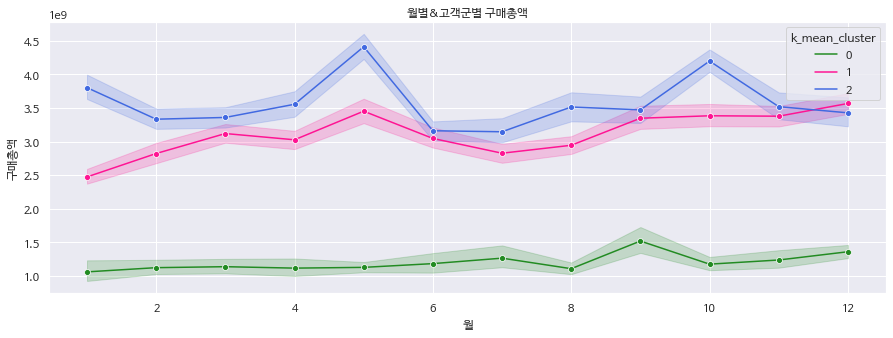

In [65]:
plt.figure(figsize=(15, 5))
sns.lineplot(data = pdde_cluster
                ,x='month'
                ,y='buy_am'
                ,estimator=np.sum
                ,hue = 'k_mean_cluster',
                marker='o',
               palette=['forestgreen', 'deeppink', 'royalblue']
                          )
plt.title('월별&고객군별 구매총액')
plt.xlabel('월')
plt.ylabel('구매총액')
plt.show()

[Text(0, 0.5, '평균지출금액'), Text(0.5, 0, '월')]

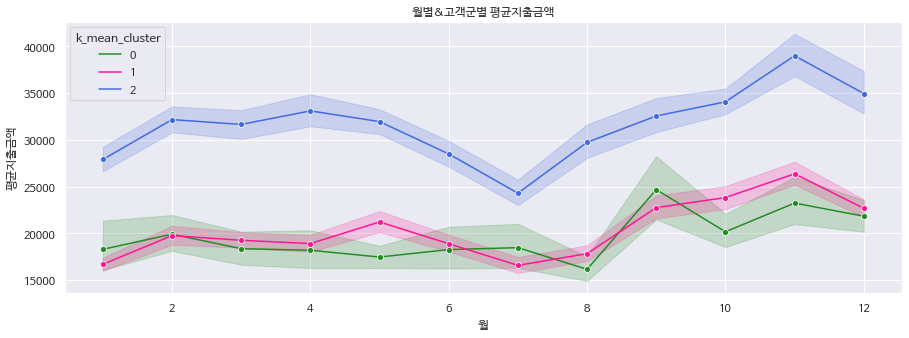

In [66]:
plt.figure(figsize=(15, 5))
ax = sns.lineplot(data = pdde_cluster
                ,x='month'
                ,y='buy_am'
                ,hue = 'k_mean_cluster'
                ,marker='o',
               palette=['forestgreen', 'deeppink', 'royalblue']
                          )
ax.set_title('월별&고객군별 평균지출금액')
ax.set(xlabel='월', ylabel='평균지출금액')

In [204]:
# # 제휴사
# plt.figure(figsize=(15, 5))
# ax = sns.lineplot(data = cop_cluster
#                 ,x='month'
#                 ,y='buy_am'
#                 ,hue = 'k_mean_cluster'
#                 ,marker='o',
#                palette=['forestgreen', 'deeppink', 'royalblue']
#                           )
# ax.set_title('월별&고객군별 평균지출금액')
# ax.set(xlabel='월', ylabel='평균지출금액')

[Text(0, 0.5, '엘페이 평균지출금액'), Text(0.5, 0, '월')]

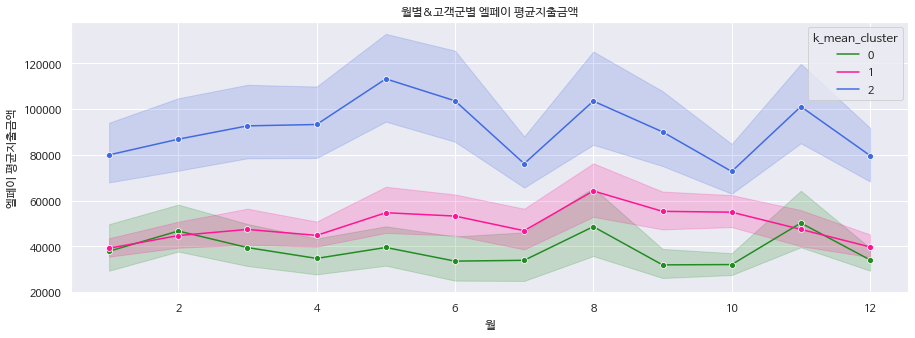

In [67]:
# 엘페이
plt.figure(figsize=(15, 5))
ax = sns.lineplot(data = lpay_cluster
                ,x='month'
                ,y='buy_am'
                ,hue = 'k_mean_cluster'
                ,marker='o',
               palette=['forestgreen', 'deeppink', 'royalblue']
                          )
ax.set_title('월별&고객군별 엘페이 평균지출금액')
ax.set(xlabel='월', ylabel='엘페이 평균지출금액')

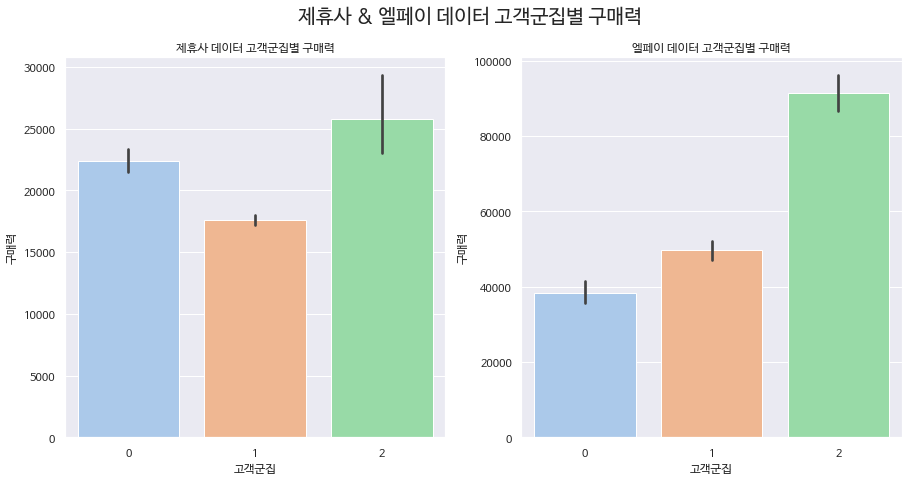

In [236]:
fig, axes = plt.subplots(1,2,figsize=(15,7))
#color = ['forestgreen','royalblue', 'deeppink']
color = sns.set_palette('pastel')
ax1 = sns.barplot(x = 'k_mean_cluster', y='buy_am', data = cop_cluster, ax = axes[0], palette = color)
ax1.set_title('제휴사 데이터 고객군집별 구매력')
ax1.set(xlabel='고객군집', ylabel='구매력')

ax2 = sns.barplot(x = 'k_mean_cluster', y='buy_am', data = lpay_cluster, ax = axes[1], palette = color)
ax2.set_title('엘페이 데이터 고객군집별 구매력')
ax2.set(xlabel='고객군집', ylabel='구매력')

plt.suptitle('제휴사 & 엘페이 데이터 고객군집별 구매력', fontsize=20)
plt.show()

In [ ]:
# 엘페이 및 제휴사 데이터에서도 2번 군집의 평균소비금액이 높게 나타났다.

# 2번 고객군 상품 예측
- 상품 대분류 비중, 상품 중분류 비중

In [68]:
pdde_cluster.columns

Index(['cust', 'ma_fem_dv', 'ages', 'zon_hlv', 'rct_no', 'chnl_dv', 'cop_c',
       'br_c', 'pd_c', 'de_dt', 'de_hr', 'buy_am', 'buy_ct', 'pd_nm',
       'clac_hlv_nm', 'clac_mcls_nm', 'zon_mcls', '날짜', '강수량(mm)', '평균기온(℃)',
       '최저기온(℃)', '최고기온(℃)', '평균습도(%rh)', '최저습도(%rh)', '일조합(hr)', '일사합(MJ/m2)',
       'year', 'month', '요일', '일교차', 'holiday_anniversary', 'k_mean_cluster'],
      dtype='object')

In [73]:
# 고객군마다 비슷한 상품을 구매한다는 것을 보여주는 지표
# 클러스터링과 상품예측이 잘되었음

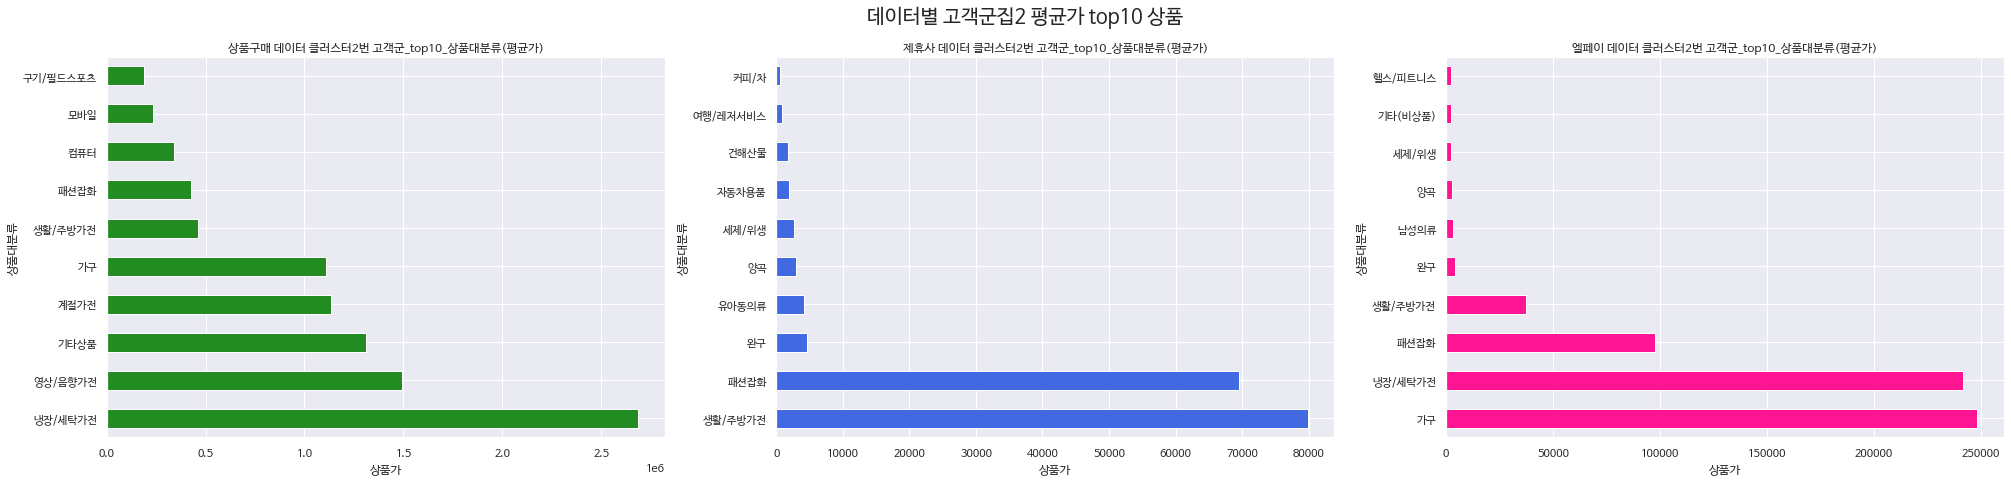

In [228]:
fig, axes = plt.subplots(1,3,figsize=(34,7))
color = ['forestgreen','royalblue', 'deeppink']
ax1 = pdde_cluster_2.groupby('clac_hlv_nm')['상품가'].mean().sort_values(ascending=False).head(10).plot(kind='barh', color = color[0], ax = axes[0])
ax1.set_title('상품구매 데이터 클러스터2번 고객군_top10_상품대분류(평균가)')
ax1.set(xlabel='상품가', ylabel='상품대분류')


ax2 = cop_cluster_2.groupby('clac_hlv_nm')['상품가'].mean().sort_values(ascending=False).head(10).plot(kind='barh', color = color[1],ax = axes[1])
ax2.set_title('제휴사 데이터 클러스터2번 고객군_top10_상품대분류(평균가)')
ax2.set(xlabel='상품가', ylabel='상품대분류')

ax3 = lpay_cluster_2.groupby('clac_hlv_nm')['상품가'].mean().sort_values(ascending=False).head(11)[1:].plot(kind='barh', color = color[2],ax = axes[2])
ax3.set_title('엘페이 데이터 클러스터2번 고객군_top10_상품대분류(평균가)')
ax3.set(xlabel='상품가', ylabel='상품대분류')

plt.suptitle('데이터별 고객군집2 평균가 top10 상품', fontsize=20)
plt.show()